In [1]:
import os
import sys
from collections import defaultdict
from pathlib import Path
from typing import Dict, List, Literal, Optional, Tuple, Union
import logging
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

notebook_path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
project_dir = notebook_path.parent.parent
sys.path.append(str(project_dir))
import src.utils.custom_log as custom_log
from src.utils.Csv import Csv
from src.utils.set_rcparams import set_rcparams

os.chdir(project_dir)
LOG = logging.getLogger(__name__)
custom_log.init_logger(log_lvl=logging.INFO)
LOG.info("Log initialized")

2025-01-05 19:22:32,629     INFO  MainProcess  MainThread Log initialized


In [2]:
set_rcparams()
PIC_DIR = Path("reports/figures/validity_chain") / notebook_path.stem
PIC_DIR.mkdir(parents=True, exist_ok=True)
PAGE_WIDTH = 448.13095 / 72 -0.2

2025-01-05 19:22:32,642     INFO  MainProcess  MainThread Setting rcparams for matplotlib
2025-01-05 19:22:32,721     INFO  MainProcess  MainThread Using style src/visualization/dissertation.mplstyle


# Get Data

In [3]:
def get_data(b_path: Path, cfc: Literal["A", "B", "C", "D", "X"]) -> pd.DataFrame:
    case_injs = []
    for inj_data in b_path.rglob("injury_criteria.csv.zip"):
        LOG.info("Process %s", inj_data.parent.stem)
        db = Csv(csv_path=inj_data, compress=True).read()
        vals = db.loc[cfc]
        vals.name = int(inj_data.parent.stem[1:])
        case_injs.append(vals)

    db = pd.concat(case_injs, axis=1).T
    db.index.name = "SID"
    db.rename(columns={"Chest_Deflection": "Chest_Defl.", "Femur_Fz_Max": "Femur_Fz"}, inplace=True)

    return db


DB: pd.DataFrame = get_data(
    b_path=Path("/mnt") / "q" / "Honda_Accord_2014_Sled_with_HIII_Rigid_Seat_SpeedOpt_BigDOE" / "doe_para_infl_20230921_163501",
    cfc="D",
)


DB

2025-01-05 19:22:32,779     INFO  MainProcess  MainThread Process V0000000
2025-01-05 19:22:32,780     INFO  MainProcess  MainThread Read /mnt/q/Honda_Accord_2014_Sled_with_HIII_Rigid_Seat_SpeedOpt_BigDOE/doe_para_infl_20230921_163501/V0000000/injury_criteria.csv.zip
2025-01-05 19:22:32,852     INFO  MainProcess  MainThread Process V0000001
2025-01-05 19:22:32,854     INFO  MainProcess  MainThread Read /mnt/q/Honda_Accord_2014_Sled_with_HIII_Rigid_Seat_SpeedOpt_BigDOE/doe_para_infl_20230921_163501/V0000001/injury_criteria.csv.zip
2025-01-05 19:22:32,907     INFO  MainProcess  MainThread Process V0000002
2025-01-05 19:22:32,909     INFO  MainProcess  MainThread Read /mnt/q/Honda_Accord_2014_Sled_with_HIII_Rigid_Seat_SpeedOpt_BigDOE/doe_para_infl_20230921_163501/V0000002/injury_criteria.csv.zip
2025-01-05 19:22:32,961     INFO  MainProcess  MainThread Process V0000003
2025-01-05 19:22:32,963     INFO  MainProcess  MainThread Read /mnt/q/Honda_Accord_2014_Sled_with_HIII_Rigid_Seat_SpeedOp

,Head_HIC15,Head_HIC36,Head_a3ms,Neck_Nij,Neck_Fz_Max_Compression,Neck_Fz_Max_Tension,Neck_My_Max,Neck_Fx_Shear_Max,Chest_Defl.,Chest_a3ms,Femur_Fz
SID,,,,,,,,,,,
0,311.504,433.862,56.620,0.576,0.030,0.966,36.415,0.800,17.347,60.277,1.840
1,314.835,465.655,63.847,0.563,0.032,0.933,32.138,0.754,20.041,60.521,1.848
2,288.762,453.943,61.979,0.600,0.041,1.097,36.421,0.635,28.556,57.645,1.971
3,245.882,400.129,52.285,0.711,0.005,1.566,44.456,0.833,24.306,60.638,1.849
4,314.333,491.708,63.832,0.563,0.015,0.933,30.909,0.754,20.041,60.521,1.848
5,289.664,494.571,58.110,0.598,0.004,1.183,43.418,0.831,20.495,57.797,1.795
6,311.347,434.720,59.473,0.513,0.010,0.879,40.711,0.719,26.211,47.743,1.909
7,131.411,237.809,46.292,0.593,0.063,1.144,43.671,0.853,28.563,45.910,1.831
8,597.828,731.285,75.706,0.449,0.091,0.742,37.108,0.780,14.145,66.739,2.077


In [4]:
LIMS = {
        "Head_a3ms": [80, "g"],
        "Neck_Nij": [1, ""],
        "Chest_a3ms": [60, "g"],
        "Chest_Defl.": [63, "mm"],
        "Femur_Fz": [10, "kN"],
    }

LIM_RENAMER = {
    "Head_a3ms": "Head HAC$_3$",
    "Neck_Nij": "Neck Nij",
    "Chest_a3ms": "Chest CAC$_3$",
    "Chest_Defl.": "Chest CDC",
    "Femur_Fz": "Femur FCC",
}

DB_SCAL = pd.DataFrame(index=DB.index)
for lim in LIMS.keys():
    DB_SCAL[lim] = DB[lim] / LIMS[lim][0]

DB_SCAL


,Head_a3ms,Neck_Nij,Chest_a3ms,Chest_Defl.,Femur_Fz
SID,,,,,
0,0.707750,0.576,1.004617,0.275349,0.1840
1,0.798088,0.563,1.008683,0.318111,0.1848
2,0.774737,0.600,0.960750,0.453270,0.1971
3,0.653562,0.711,1.010633,0.385810,0.1849
4,0.797900,0.563,1.008683,0.318111,0.1848
5,0.726375,0.598,0.963283,0.325317,0.1795
6,0.743413,0.513,0.795717,0.416048,0.1909
7,0.578650,0.593,0.765167,0.453381,0.1831
8,0.946325,0.449,1.112317,0.224524,0.2077


In [5]:
DOE = pd.read_excel(
    Path("/mnt")
    / "q"
    / "Honda_Accord_2014_Sled_with_HIII_Rigid_Seat_SpeedOpt_BigDOE"
    / "doe_para_infl_20230921_163501"
    / "doe.xlsx",
    index_col=0,
)
DOE["SLL"] /= 1000
DOE

,PAB_M_Scal,PAB_Vent_T,Pulse_Angle,Pulse_X_Scale,SLL,V_Init,PERC
0,0.9,0.10,0,1.0,2.34,-15560,5
1,1.0,0.10,0,1.0,2.34,-15560,5
2,1.1,0.10,0,1.0,2.34,-15560,5
3,1.0,0.07,0,1.0,2.34,-15560,5
4,1.0,0.13,0,1.0,2.34,-15560,5
5,1.0,0.10,-10,1.0,2.34,-15560,5
6,1.0,0.10,10,1.0,2.34,-15560,5
7,1.0,0.10,0,0.8,2.34,-15560,5
8,1.0,0.10,0,1.2,2.34,-15560,5
9,1.0,0.10,0,1.0,2.14,-15560,5


In [6]:
PARAS = {
    "Pulse_X_Scale": "PSCAL [1]",
    "Pulse_Angle": "ALPHA [deg]",
    "PAB_M_Scal": "PABSCAL [1]",
    "PAB_Vent_T": "PABVENT [s]",
    "SLL": "SLL [kN]",
}
# drop initial velocity as motion is applied by acceleration curve --> initial velocity has no effect :(

# Evaluate

/tmp/ipykernel_56016/2590868211.py:34: UserWarning: Glyph 8201 (\N{THIN SPACE}) missing from font(s) TeX Gyre Heros.
  fig.savefig(PIC_DIR / f"factor_influences.{suffix}")
2025-01-05 19:22:43,498     INFO  MainProcess  MainThread maxp pruned
2025-01-05 19:22:43,504     INFO  MainProcess  MainThread cmap pruned
2025-01-05 19:22:43,506     INFO  MainProcess  MainThread post pruned
2025-01-05 19:22:43,508     INFO  MainProcess  MainThread CFF  pruned
2025-01-05 19:22:43,514     INFO  MainProcess  MainThread GPOS pruned
2025-01-05 19:22:43,524     INFO  MainProcess  MainThread GSUB pruned
2025-01-05 19:22:43,526     INFO  MainProcess  MainThread Missing glyphs for requested Unicodes: ['U+2009']
2025-01-05 19:22:43,526     INFO  MainProcess  MainThread Added .notdef to subset
2025-01-05 19:22:43,527     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 46 glyphs before
2025-01-05 19:22:43,528     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'F'

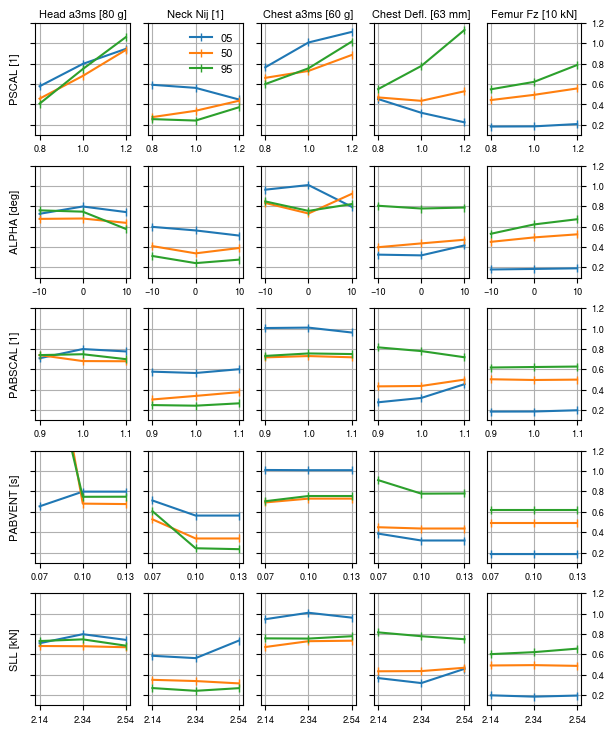

In [7]:
def plot_influences():
    mids = [1, 14, 27]

    fig, ax = plt.subplots(
        ncols=len(LIMS.keys()),
        nrows=len(PARAS),
        constrained_layout=True,
        figsize=(PAGE_WIDTH, 1.2 * PAGE_WIDTH),
    )

    for m, perc in enumerate(DOE["PERC"].unique()):
        doe_perc = DOE[DOE["PERC"].eq(perc)]
        for i, para in enumerate(PARAS):
            idxs = [doe_perc[para].idxmin(), mids[m], doe_perc[para].idxmax()]
            ax[i, 0].set_ylabel(PARAS[para])

            for j, inj_val in enumerate(LIMS.keys()):
                unit = str(LIMS[inj_val][0]) + (("\u2009" + LIMS[inj_val][1]) if LIMS[inj_val][1] else "")
                ax[0, j].set_xlabel(f"{inj_val.replace('_', ' ')} [{unit}]")
                ax[0, j].xaxis.set_label_position("top")
                ax[i, j].plot(
                    doe_perc.loc[idxs, para], DB_SCAL.loc[idxs, inj_val], label=f"{perc:02.0f}", marker="|"
                )

                ax[i, j].set_xticks(doe_perc.loc[idxs, para])
                ax[i, j].grid()
                ax[i, j].set_ylim([0.1, 1.2])
                if j != len(LIMS.keys()) - 1:
                    ax[i, j].set_yticklabels([])
            ax[i, -1].yaxis.tick_right()
    ax[0, 1].legend()

    for suffix in ("png", "pdf"):
        fig.savefig(PIC_DIR / f"factor_influences.{suffix}")


plot_influences()

In [8]:
def get_effects() -> Dict[str, pd.DataFrame]:
    mids = [1, 14, 27]

    all_effects = {}
    for m, perc in enumerate(DOE["PERC"].unique()):
        doe_perc = DOE[DOE["PERC"].eq(perc)]
        effects = defaultdict(dict)
        for i, para in enumerate(PARAS):
            idxs = [doe_perc[para].idxmin(), mids[m], doe_perc[para].idxmax()]

            for j, inj_val in enumerate(LIMS.keys()):
                LOG.debug("Dummy %s, Factor %s, Injury %s", perc, para, inj_val)

                m1 = np.abs(DB_SCAL.loc[idxs[1], inj_val]-DB_SCAL.loc[idxs[0], inj_val])
                m2 = np.abs(DB_SCAL.loc[idxs[2], inj_val]-DB_SCAL.loc[idxs[1], inj_val])
                m3 = np.abs(DB_SCAL.loc[idxs[2], inj_val]-DB_SCAL.loc[idxs[0], inj_val]) / 2
                effects[PARAS[para].split()[0]][inj_val.replace("_", " ")] = max(m1, m2, m3)
        all_effects[perc] = pd.DataFrame(effects).T

    return all_effects


EFFECTS = get_effects()
EFFECTS

{5:          Head a3ms  Neck Nij  Chest a3ms  Chest Defl.  Femur Fz
 PSCAL     0.219438     0.114    0.243517     0.135270    0.0229
 ALPHA     0.071713     0.050    0.212967     0.097937    0.0061
 PABSCAL   0.090338     0.037    0.047933     0.135159    0.0123
 PABVENT   0.144525     0.148    0.001950     0.067698    0.0001
 SLL       0.088825     0.172    0.063417     0.139698    0.0130,
 50:          Head a3ms  Neck Nij  Chest a3ms  Chest Defl.  Femur Fz
 PSCAL     0.255987     0.098    0.156200     0.093873    0.0630
 ALPHA     0.042475     0.071    0.192167     0.037508    0.0435
 PABSCAL   0.058700     0.037    0.012900     0.062429    0.0071
 PABVENT   2.366013     0.188    0.037383     0.012714    0.0000
 SLL       0.010262     0.023    0.057217     0.032698    0.0074,
 95:          Head a3ms  Neck Nij  Chest a3ms  Chest Defl.  Femur Fz
 PSCAL     0.339437     0.130    0.261883     0.353556    0.1661
 ALPHA     0.169887     0.070    0.092767     0.027048    0.0917
 PABSCAL   0

2025-01-05 20:13:11,087     INFO  MainProcess  MainThread maxp pruned
2025-01-05 20:13:11,106     INFO  MainProcess  MainThread cmap pruned
2025-01-05 20:13:11,107     INFO  MainProcess  MainThread kern dropped
2025-01-05 20:13:11,109     INFO  MainProcess  MainThread post pruned
2025-01-05 20:13:11,110     INFO  MainProcess  MainThread FFTM dropped
2025-01-05 20:13:11,116     INFO  MainProcess  MainThread GPOS pruned
2025-01-05 20:13:11,125     INFO  MainProcess  MainThread GSUB pruned
2025-01-05 20:13:11,138     INFO  MainProcess  MainThread glyf pruned
2025-01-05 20:13:11,141     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-05 20:13:11,142     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-05 20:13:11,144     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 5 glyphs before
2025-01-05 20:13:11,146     INFO  MainProcess  MainThread Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'three']
2025-01-05 20:13:11,149     INF

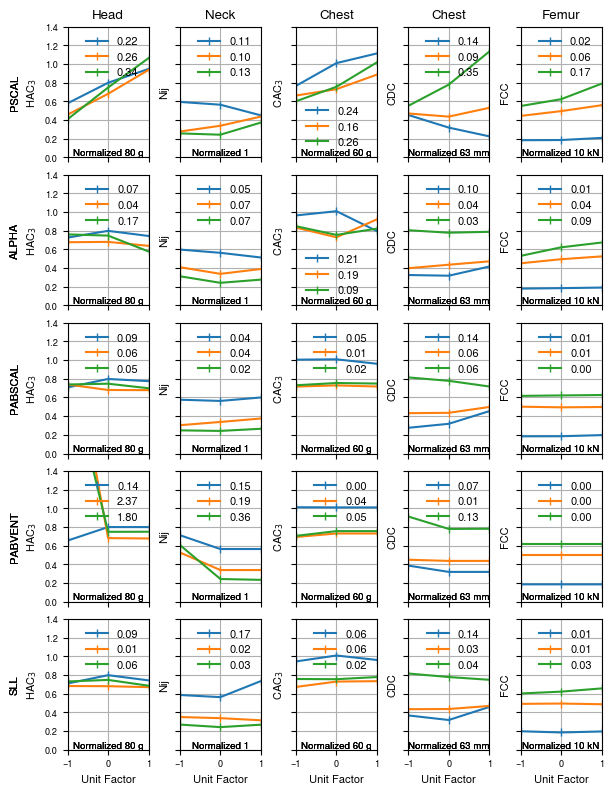

In [31]:
def plot_influences_2():
    mids = [1, 14, 27]

    fig, ax = plt.subplots(
        ncols=len(LIMS.keys()),
        nrows=len(PARAS),
        layout="constrained",
        sharex=True,
        sharey=True,
    )

    for m, perc in enumerate(DOE["PERC"].unique()):
        doe_perc = DOE[DOE["PERC"].eq(perc)]
        for i, para in enumerate(PARAS):
            idxs = [doe_perc[para].idxmin(), mids[m], doe_perc[para].idxmax()]
            ax[i,0].annotate(PARAS[para].split()[0], xy=(-0.65, 0.5), xycoords="axes fraction", ha="center", va="center", rotation=90)
            #ax[i, 0].set_ylabel(PARAS[para].split()[0])

            for j, inj_val in enumerate(LIMS.keys()):
                unit = str(LIMS[inj_val][0]) + ((" " + LIMS[inj_val][1]) if LIMS[inj_val][1] else "")
                # ax[0, j].set_xlabel(f"{LIM_RENAMER[inj_val]}\n\nNormalized by {unit}")
                ax[0, j].set_title(LIM_RENAMER[inj_val].split()[0])
                # ax[0, j].xaxis.set_label_position("top")
                ax[i,j].annotate(f"Normalized {unit}", xy=(0.5, 0.0), xycoords="axes fraction", ha="center", va="bottom", fontsize=7, weight="ultralight")

                ax[i, j].plot(
                    [-1, 0, 1],
                    DB_SCAL.loc[idxs, inj_val],
                    label=f"{EFFECTS[perc].loc[PARAS[para].split()[0], inj_val.replace('_', ' ')]:.2f}",
                    marker="|",
                )

                # ax[i, j].set_xticks(doe_perc.loc[idxs, para])
                ax[i, j].grid()
                ax[i, j].set_ylim([0, 1.4])
                ax[i, j].set_xlim([-1, 1])
                ax[i, j].legend()

                #ax[i, j].set_xlabel(PARAS[para].split()[0])
                ax[i, j].set_ylabel(LIM_RENAMER[inj_val].split()[1])

                #if j !=0:
                #    ax[i, j].set_yticklabels([])
                if i == len(PARAS) - 1:
                    ax[i, j].set_xlabel("Unit Factor")
            #ax[i, -1].yaxis.tick_right()

    #fig.align_ylabels(ax)
    fig.set_figheight(1.3 * PAGE_WIDTH)
    fig.set_figwidth(PAGE_WIDTH)
    for suffix in ("pdf",):
        fig.savefig(PIC_DIR / f"factor_influences2.{suffix}")


plot_influences_2()

2025-01-05 19:23:04,438     INFO  MainProcess  MainThread maxp pruned
2025-01-05 19:23:04,450     INFO  MainProcess  MainThread cmap pruned
2025-01-05 19:23:04,452     INFO  MainProcess  MainThread post pruned
2025-01-05 19:23:04,455     INFO  MainProcess  MainThread CFF  pruned
2025-01-05 19:23:04,461     INFO  MainProcess  MainThread GPOS pruned
2025-01-05 19:23:04,486     INFO  MainProcess  MainThread GSUB pruned
2025-01-05 19:23:04,488     INFO  MainProcess  MainThread Added .notdef to subset
2025-01-05 19:23:04,491     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 43 glyphs before
2025-01-05 19:23:04,492     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'L', 'N', 'P', 'S', 'T', 'V', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'nine', 'one', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'z', 'zero']
2025-01-05 19:23:04,494     INFO  MainProcess  MainThread G

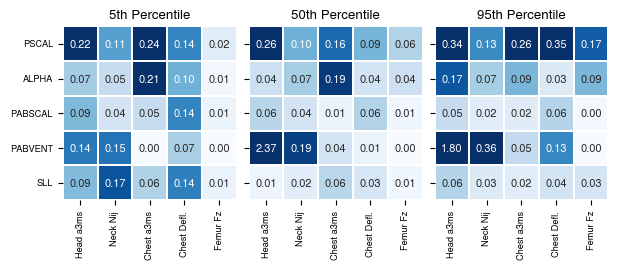

In [10]:
def plot_effects():
    width = 448.13095 / 72
    fig, ax = plt.subplots(ncols=len(EFFECTS.keys()), sharex="all", sharey="all", figsize=(width, 0.5*width))
    for i, perc in enumerate(EFFECTS.keys()):
        sns.heatmap(EFFECTS[perc], ax=ax[i], cmap="Blues", square=True, annot=True, linewidths=0.1, cbar=False, fmt=".2f", vmin=0, vmax=0.2)
        ax[i].set_title(f"{perc}th Percentile")

    for suffix in ("png", "pdf"):
        fig.savefig(PIC_DIR / f"factor_effects.{suffix}")

plot_effects()

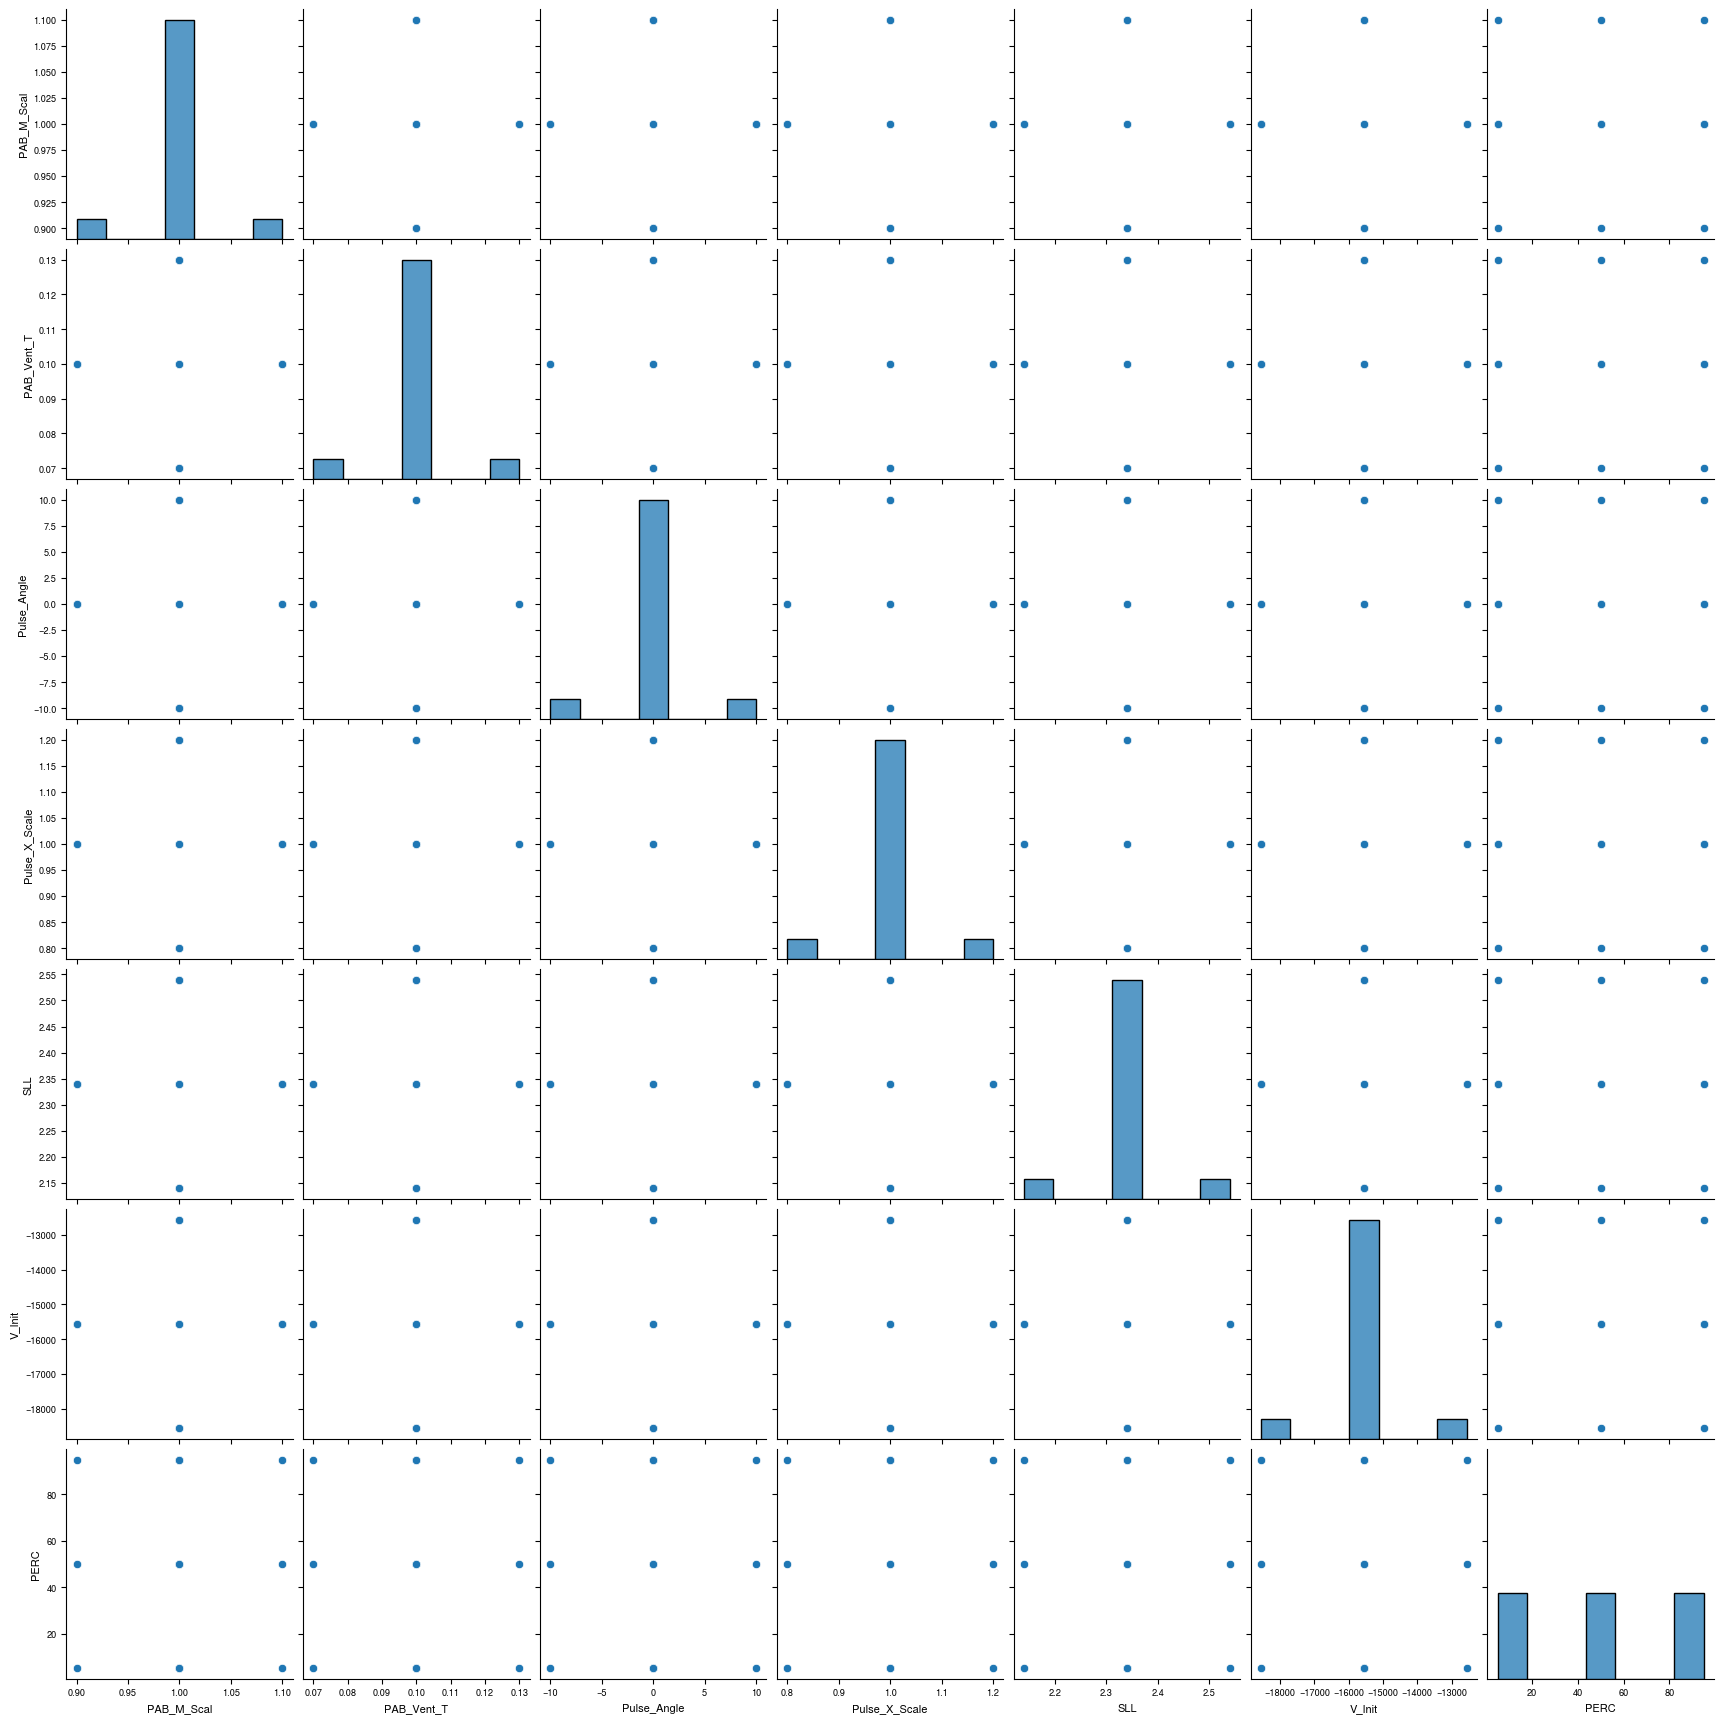

In [11]:
sns.pairplot(DOE)